### 0. Imports and setup

In [1]:
from src.dataset import Colored3DMNIST, DataLoader
from torchvision import transforms, datasets
from IPython.display import clear_output
from matplotlib.colors import to_hex
from src.nn import UNet, ResNet_D
# from src.plot import plot_img
from pathlib import Path
from tqdm import tqdm
from matplotlib.colors import rgb2hex



import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import src.data as data
import torch.nn as nn
import numpy as np
import torchvision
import torch
import gc

In [2]:
if torch.cuda.is_available():
    torch.cuda.set_device(f"cuda:0")
torch.manual_seed(42)
np.random.seed(42)

### 1. Getting the data ready

In [43]:
BATCH_SIZE = 32

def random_color(im):
    hue = np.random.choice([60, 120, 240, 280])
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    c_im = torch.zeros((3, im.shape[1], im.shape[2]))
    H = round(hue/60) % 6    
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

def Add_dimension(im):
    img_3D = torch.zeros(im.shape[0], im.shape[1], im.shape[2], 16)
    for i in range(im.shape[1]):
      if i < 4 or i > 12:
        img_3D[:, :, :, i] = torch.zeros_like(im)
      else:
        img_3D[:, :, :, i] = im
    return img_3D 

TRANSFORM_3D = transforms.Compose([
    transforms.Resize(16),
    transforms.ToTensor(),
    transforms.RandomRotation(45),
    random_color,
    Add_dimension,
])

x_train_a = np.load(file='./data/x_train_a_c.npy')
mnist_train_a = Colored3DMNIST(x_train_a)

# indices = mnist_train_a.targets == 3
# mnist_train_a.data, mnist_train_a.targets = mnist_train_a.data[indices], mnist_train_a.targets[indices]

mnist_loader_a = torch.utils.data.DataLoader(mnist_train_a, batch_size=BATCH_SIZE, shuffle=True)


# mnist_train_b = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM_3D)
x_train_b = np.load(file='./data/x_train_b_c.npy')
mnist_train_b = Colored3DMNIST(x_train_a)

# indices = mnist_train_b.targets == 5
# mnist_train_b.data, mnist_train_b.targets = mnist_train_b.data[indices], mnist_train_b.targets[indices]

mnist_loader_b = torch.utils.data.DataLoader(mnist_train_b, batch_size=BATCH_SIZE, shuffle=True)


# mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=TRANSFORM_3D)
x_test = np.load(file='./data/x_test_c.npy')
mnist_test = Colored3DMNIST(x_test)

# indices = mnist_test.targets == 3
# mnist_test.data, mnist_test.targets = mnist_test.data[indices], mnist_test.targets[indices]

mnist_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True)

Let's plot a number:

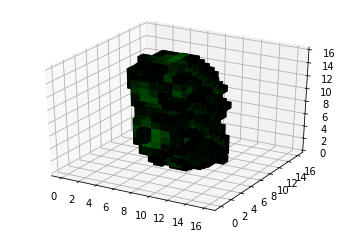

In [44]:
def plot_img(img):
    fig = plt.figure()
    ax = plt.axes(projection="3d")

    color = np.array([rgb2hex(rgb) for rgb in img.numpy().reshape(3, -1).T])
    color = color.reshape(*img.shape[1:])
    
    if torch.any(img[0, ...]):
        img = img[0, ...]
    elif torch.any(img[1, ...]):
        img = img[1, ...]
    else:
        img = img[2, ...]
    
    ax.voxels(img, facecolors=color)
    plt.show()


plot_img(next(iter(mnist_loader_test))[0])

### 3. Preparation for the training

In [47]:
# Taken from https://github.com/iamalexkorotin/NeuralOptimalTransport/blob/main/src/tools.py
def weights_init_D(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
        
def weights_init_mlp(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

In [48]:
f = ResNet_D(16, nc=3).cuda()
f.apply(weights_init_D)

T = UNet(3, 3).cuda()

In [49]:
T_opt = torch.optim.Adam(T.parameters(), lr=1e-5, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-4, weight_decay=1e-10)

In [50]:
iter_train_a = iter(mnist_loader_a)
iter_train_b = iter(mnist_loader_b)
iter_test = iter(mnist_loader_test)

def sample_train_a():
    global mnist_loader_a, iter_train_a
    try:
        return next(iter_train_a)
    except StopIteration:
        iter_train_a = iter(mnist_loader_a)
        return next(iter_train_a)

def sample_train_b():
    global mnist_loader_b, iter_train_b
    try:
        return next(iter_train_b)
    except StopIteration:
        iter_train_b = iter(mnist_loader_b)
        return next(iter_train_b)

def sample_test():
    global mnist_loader_test, iter_test
    try:
        return next(iter_test)
    except StopIteration:
        iter_test = iter(mnist_loader_test)
        return next(iter_test)

In [51]:
T_opt = torch.optim.Adam(T.parameters(), lr=1e-5, weight_decay=1e-10)
f_opt = torch.optim.Adam(filter(lambda p: p.requires_grad, f.parameters()), lr=1e-4, weight_decay=1e-10)

In [52]:
def save_model(e, t, F, o_t, o_F, l_t, l_F, path):
    torch.save({
                'epoch': e,
                'T_state_dict': t.state_dict(),
                'f_state_dict': F.state_dict(),
                'T_optimizer_state_dict': o_t.state_dict(),
                'f_optimizer_state_dict': o_F.state_dict(),
                'T_loss': l_t,
                'f_loss': l_F
                }, path)

def load_model(F, t, o_t, o_F, path):
    checkpoint = torch.load(path)
    F.load_state_dict(checkpoint["f_state_dict"])
    t.load_state_dict(checkpoint["T_state_dict"])
    # F.eval()
    # o_F = torch.optim.Adam(filter(lambda p: p.requires_grad, f.parameters()), lr=1e-4, weight_decay=1e-10)
    # o_F.load_state_dict(checkpoint["f_optimizer_state_dict"])
    # o_t.load_state_dict(checkpoint["T_optimizer_state_dict"])
    
    return checkpoint["epoch"], F, t,  checkpoint["T_loss"], checkpoint["f_loss"]
f.train(True)
step, f, T,   T_loss, f_loss = load_model(f, T, T_opt, f_opt, "weights/OT_transfer_30000_5000.pt")

### 4. Training loop

In [11]:
def sq_cost(X, Y):
  return (X-Y).square().flatten(start_dim=1).mean(dim=1)

In [12]:
device="cuda:0"

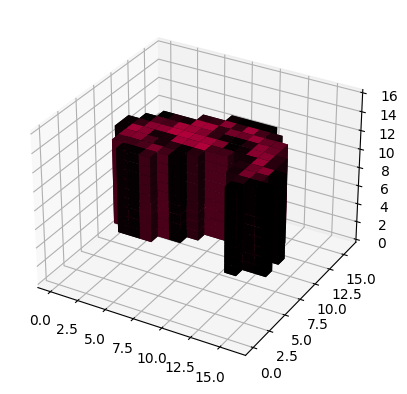

  0%|          | 0/5001 [00:00<?, ?it/s]

T_loss: -110.5103988647461;  f_loss: 6.068634033203125


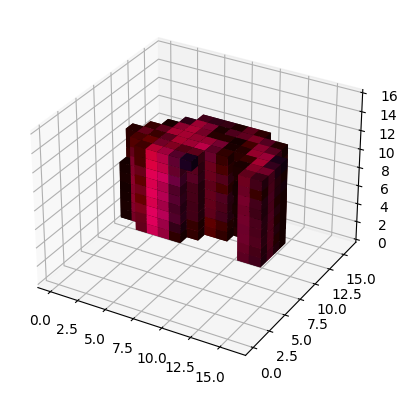

  2%|▏         | 100/5001 [01:10<57:07,  1.43it/s]

T_loss: -1.3198958979388437e+25;  f_loss: -4.110245868428732e+23


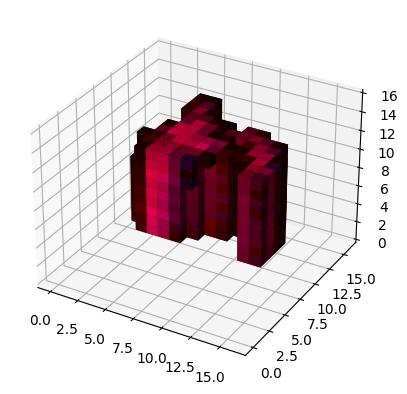

  4%|▍         | 200/5001 [02:21<56:01,  1.43it/s]  

T_loss: -1.9275641601132663e+25;  f_loss: 1.4275220427310966e+24


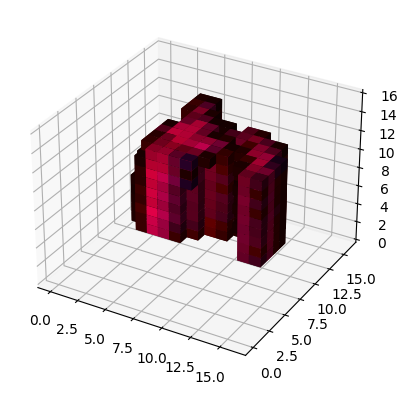

  6%|▌         | 300/5001 [03:31<54:41,  1.43it/s]  

T_loss: -2.4582168046113496e+25;  f_loss: 2.04263333555496e+24


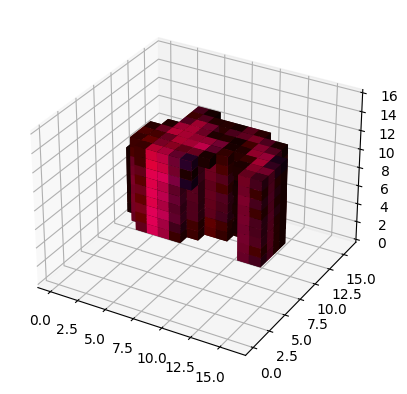

  8%|▊         | 400/5001 [04:41<53:38,  1.43it/s]  

T_loss: -2.6613537338568447e+25;  f_loss: 5.567981372109556e+24


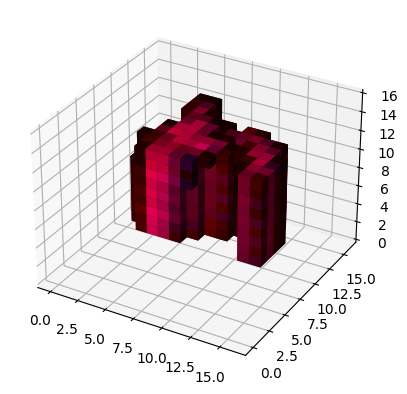

 10%|▉         | 500/5001 [05:52<52:36,  1.43it/s]  

T_loss: -2.997419976156199e+25;  f_loss: -3.8158565855994104e+24


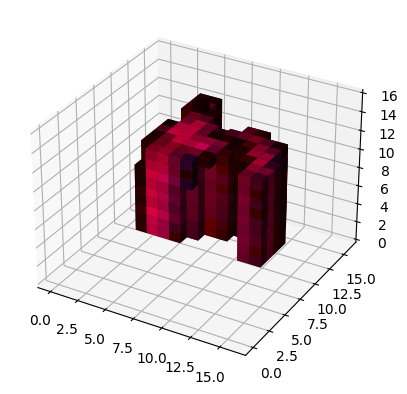

 12%|█▏        | 600/5001 [07:02<51:16,  1.43it/s]  

T_loss: -3.3910077781633984e+25;  f_loss: 2.7004742051825624e+24


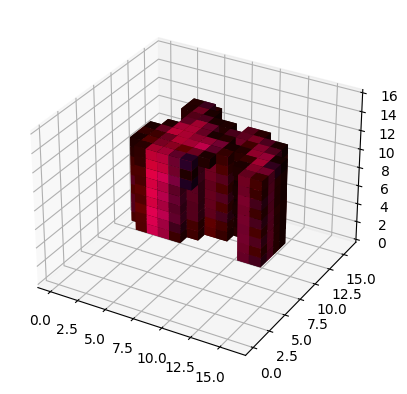

 14%|█▍        | 700/5001 [08:12<49:52,  1.44it/s]  

T_loss: -3.8511219179980237e+25;  f_loss: 3.8692045694605785e+21


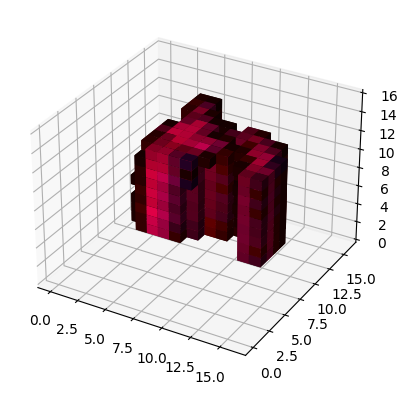

 16%|█▌        | 800/5001 [09:22<49:00,  1.43it/s]

T_loss: -3.752363814834906e+25;  f_loss: 4.550950113564699e+24


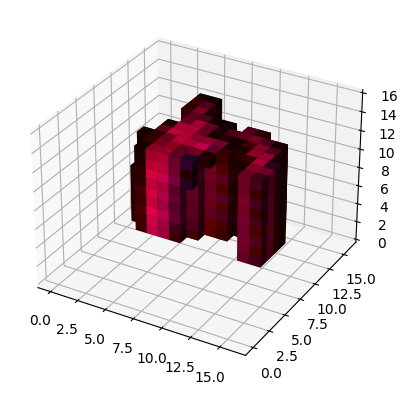

 18%|█▊        | 900/5001 [10:33<47:48,  1.43it/s]

T_loss: -4.071245300939493e+25;  f_loss: 9.4268165655577e+23


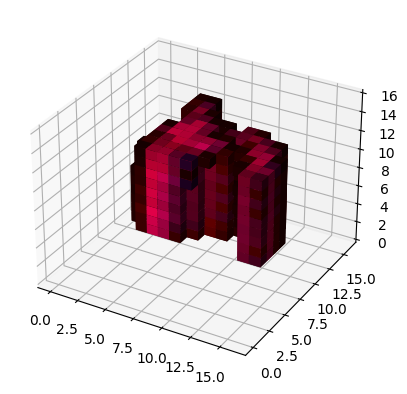

 20%|█▉        | 1000/5001 [11:43<46:34,  1.43it/s]

T_loss: -4.486384664632308e+25;  f_loss: 8.415358529566113e+23


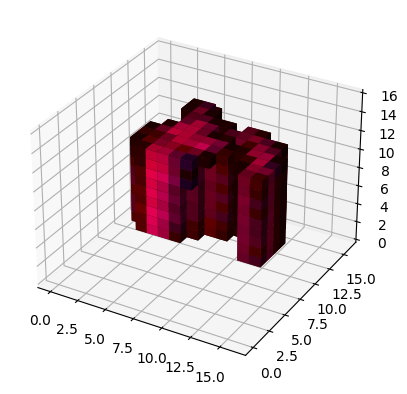

 22%|██▏       | 1100/5001 [12:54<45:22,  1.43it/s]

T_loss: -4.745775401099183e+25;  f_loss: -6.935883537994423e+23


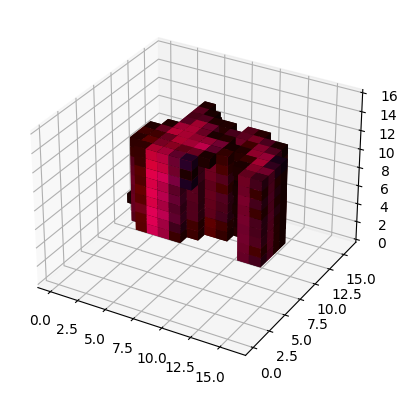

 24%|██▍       | 1200/5001 [14:04<44:18,  1.43it/s]

T_loss: -4.776790834247514e+25;  f_loss: 3.8929455290834426e+24


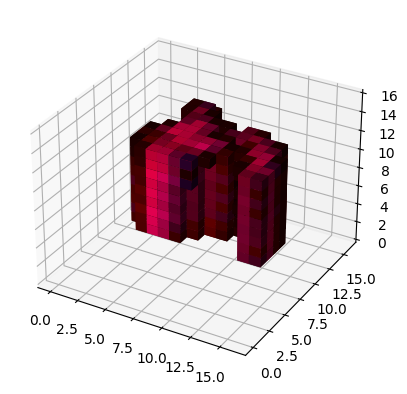

 26%|██▌       | 1300/5001 [15:14<43:08,  1.43it/s]

T_loss: -5.226878476925176e+25;  f_loss: 1.1487755988762808e+24


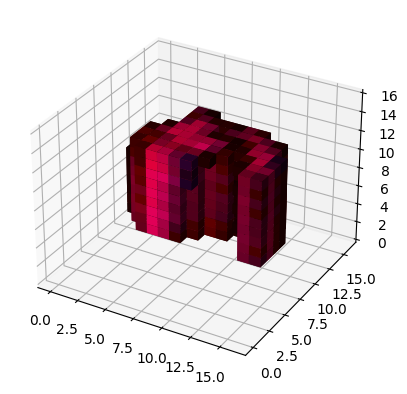

 28%|██▊       | 1400/5001 [16:24<41:51,  1.43it/s]

T_loss: -5.005569198924067e+25;  f_loss: 2.304376493059834e+24


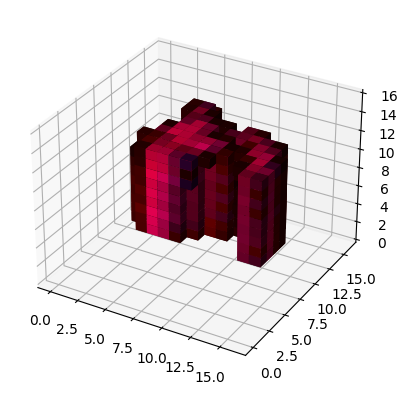

 30%|██▉       | 1500/5001 [17:35<40:50,  1.43it/s]

T_loss: -5.47790545962903e+25;  f_loss: 7.032023356420579e+24


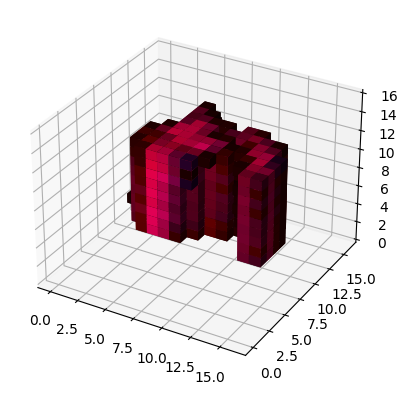

 32%|███▏      | 1600/5001 [18:45<39:38,  1.43it/s]

T_loss: -5.990368922717533e+25;  f_loss: -2.8190314293442937e+23


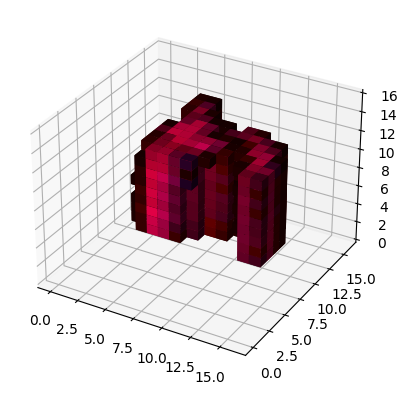

 34%|███▍      | 1700/5001 [19:55<38:12,  1.44it/s]

T_loss: -6.121297916960899e+25;  f_loss: 3.566885492522571e+24


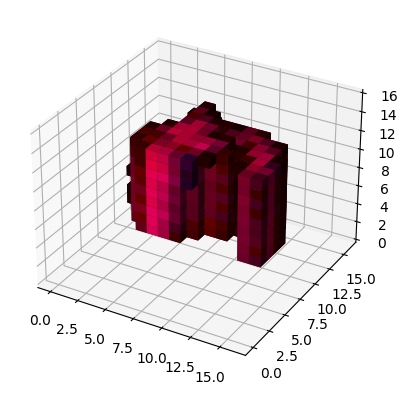

 36%|███▌      | 1800/5001 [21:06<37:11,  1.43it/s]

T_loss: -6.23830838163205e+25;  f_loss: -6.955473980200702e+24


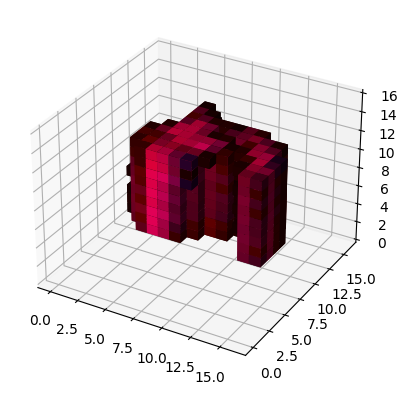

 38%|███▊      | 1900/5001 [22:16<36:06,  1.43it/s]

T_loss: -6.388246745643374e+25;  f_loss: 2.832880322457631e+24


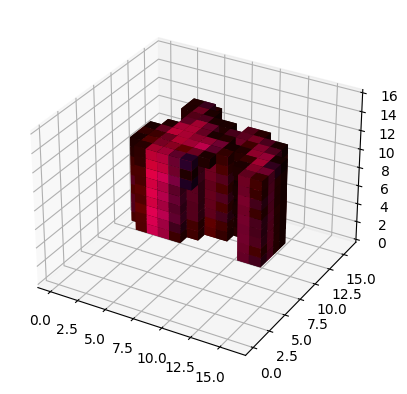

 40%|███▉      | 2000/5001 [23:26<34:58,  1.43it/s]

T_loss: -6.623315911217664e+25;  f_loss: 8.27105887404952e+24


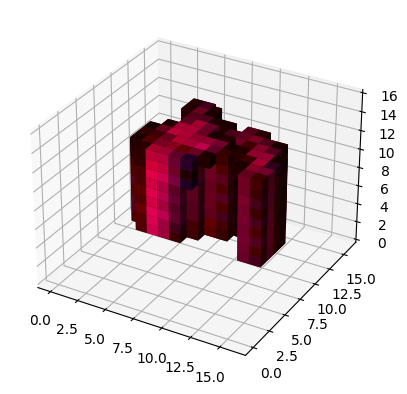

 42%|████▏     | 2100/5001 [24:37<33:47,  1.43it/s]

T_loss: -7.162553439823351e+25;  f_loss: -1.6635642740552748e+24


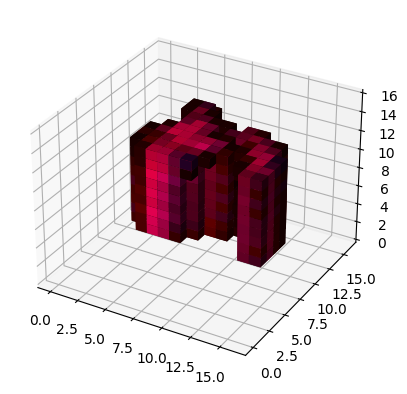

 44%|████▍     | 2200/5001 [25:47<32:32,  1.43it/s]

T_loss: -7.324764883835516e+25;  f_loss: 3.2937952815693564e+24


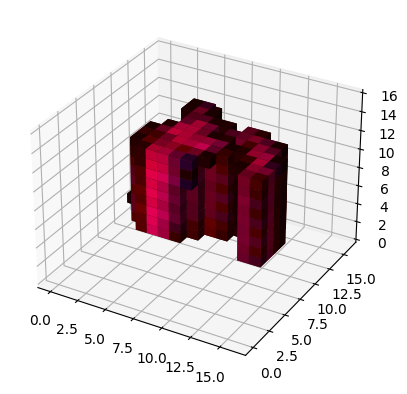

 46%|████▌     | 2300/5001 [26:57<31:29,  1.43it/s]

T_loss: -7.3393673264442645e+25;  f_loss: 5.04055898308308e+24


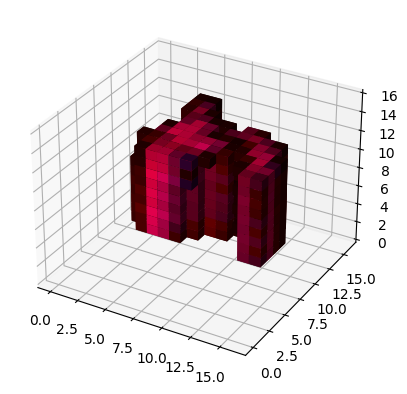

 48%|████▊     | 2400/5001 [28:08<30:18,  1.43it/s]

T_loss: -7.352150458918743e+25;  f_loss: 6.497519723512808e+24


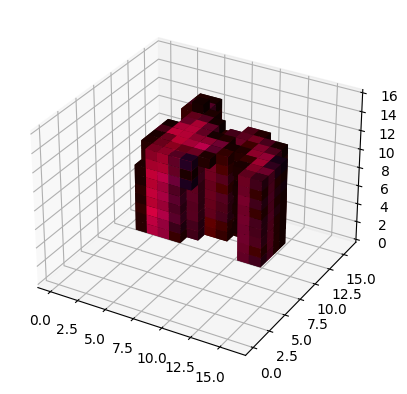

 50%|████▉     | 2500/5001 [29:18<29:11,  1.43it/s]

T_loss: -8.458546969128686e+25;  f_loss: 6.390759192186213e+24


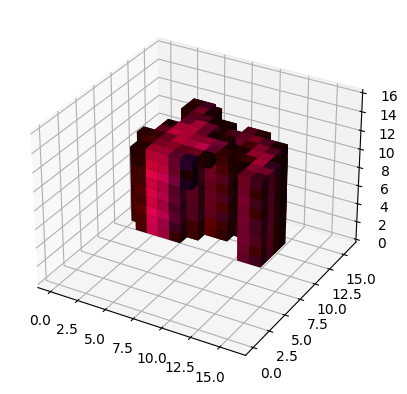

 52%|█████▏    | 2600/5001 [30:28<28:00,  1.43it/s]

T_loss: -7.992112744190106e+25;  f_loss: 3.4655898091278135e+24


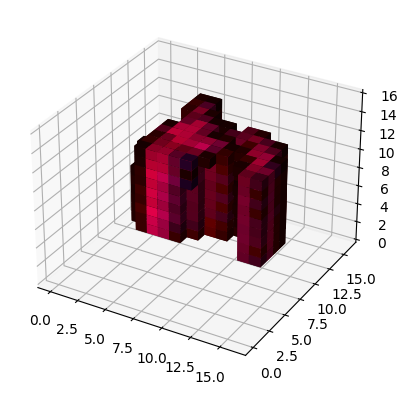

 54%|█████▍    | 2700/5001 [31:39<26:47,  1.43it/s]

T_loss: -8.33625704630364e+25;  f_loss: 2.1806818506735746e+23


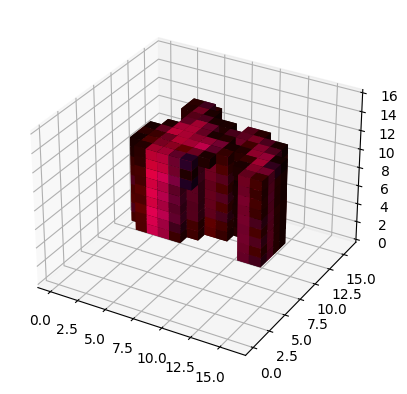

 56%|█████▌    | 2800/5001 [32:49<25:40,  1.43it/s]

T_loss: -8.941892246696838e+25;  f_loss: 1.9546354487943378e+24


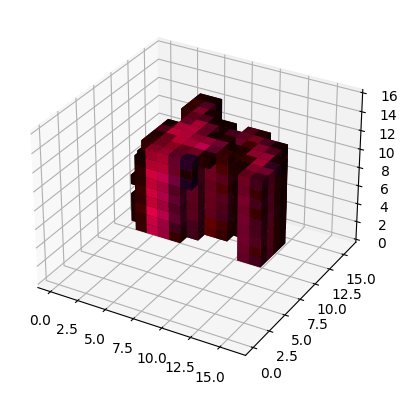

 58%|█████▊    | 2900/5001 [33:59<24:23,  1.44it/s]

T_loss: -8.582604090035993e+25;  f_loss: -1.5488799438118188e+25


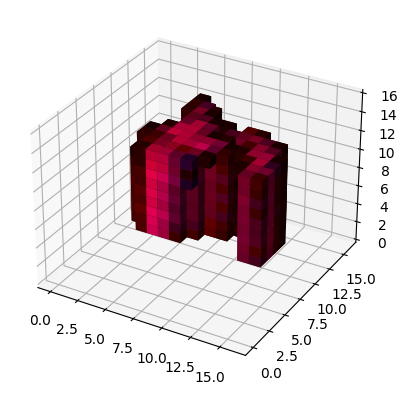

 60%|█████▉    | 3000/5001 [35:10<23:20,  1.43it/s]

T_loss: -8.903848604056423e+25;  f_loss: 6.709606551814265e+24


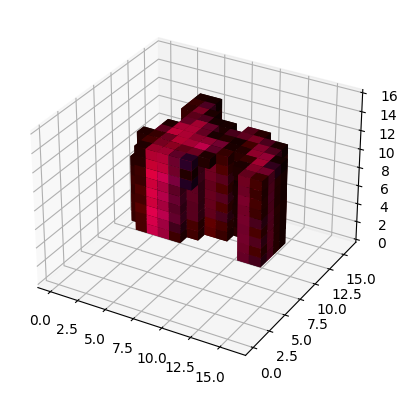

 62%|██████▏   | 3100/5001 [36:20<22:10,  1.43it/s]

T_loss: -9.702952333957484e+25;  f_loss: -5.61890591496804e+24


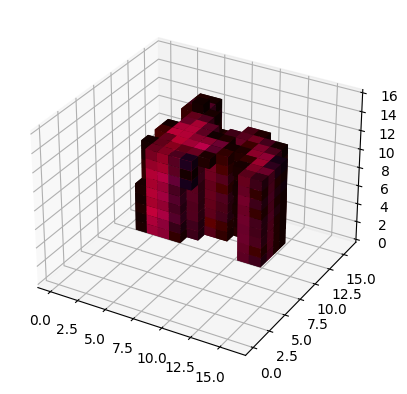

 64%|██████▍   | 3200/5001 [37:30<20:56,  1.43it/s]

T_loss: -9.936340539978057e+25;  f_loss: 7.165185790202669e+24


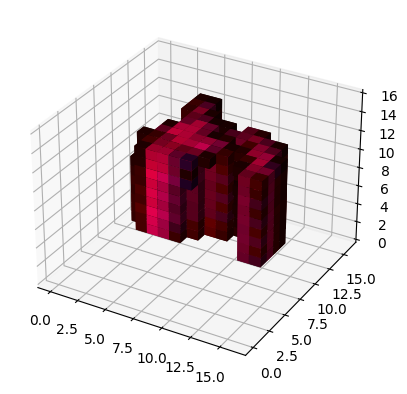

 66%|██████▌   | 3300/5001 [38:41<19:44,  1.44it/s]

T_loss: -9.127533822694225e+25;  f_loss: 7.529462868798249e+24


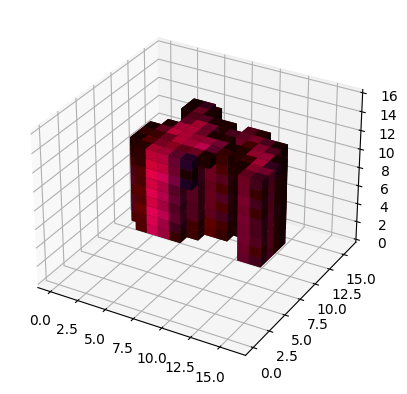

 68%|██████▊   | 3400/5001 [39:51<18:33,  1.44it/s]

T_loss: -1.0012754332628992e+26;  f_loss: 1.119009932638943e+25


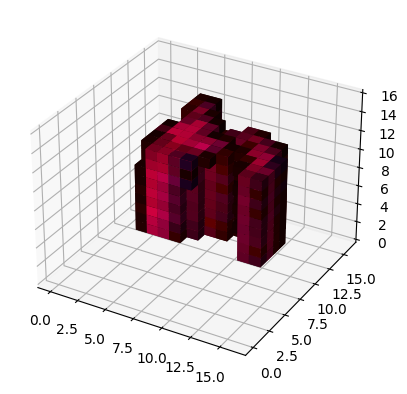

 70%|██████▉   | 3500/5001 [41:01<17:31,  1.43it/s]

T_loss: -1.020356653099024e+26;  f_loss: 5.186228309347146e+24


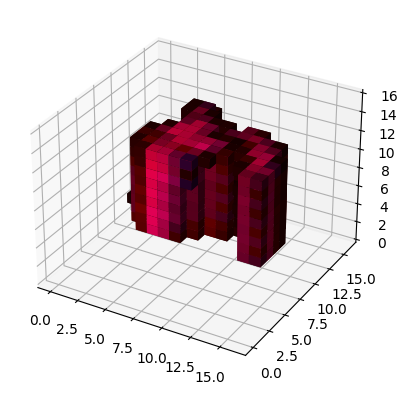

 72%|███████▏  | 3600/5001 [42:12<16:18,  1.43it/s]

T_loss: -1.0419151784305276e+26;  f_loss: 9.471167149996916e+24


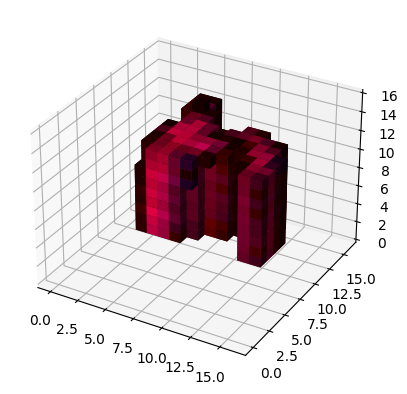

 74%|███████▍  | 3700/5001 [43:22<15:10,  1.43it/s]

T_loss: -1.0413705383117513e+26;  f_loss: 6.317410326063126e+24


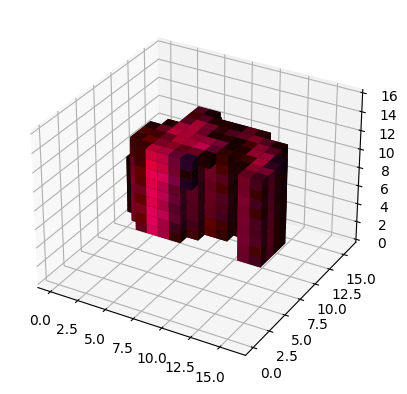

 76%|███████▌  | 3800/5001 [44:32<14:00,  1.43it/s]

T_loss: -1.125245485538179e+26;  f_loss: 4.407111626649949e+23


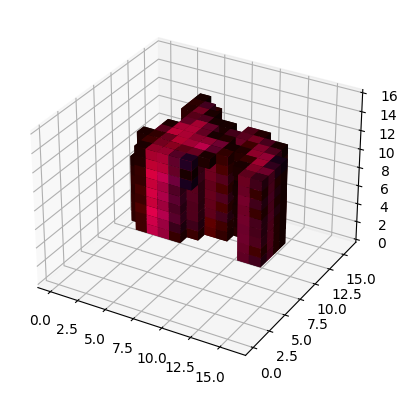

 78%|███████▊  | 3900/5001 [45:43<12:49,  1.43it/s]

T_loss: -1.119590267207502e+26;  f_loss: 9.270936966448836e+24


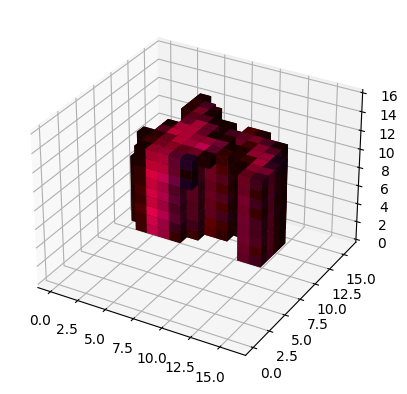

 80%|███████▉  | 4000/5001 [46:53<11:37,  1.43it/s]

T_loss: -1.2107594259755559e+26;  f_loss: -2.228551151544851e+23


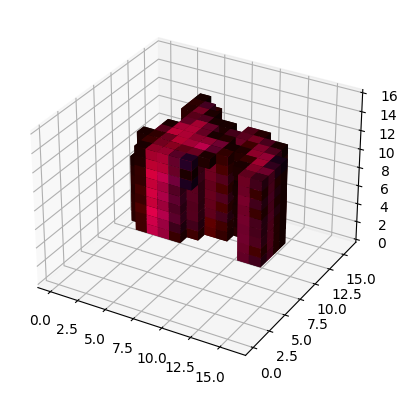

 82%|████████▏ | 4100/5001 [48:03<10:30,  1.43it/s]

T_loss: -1.1539183666565902e+26;  f_loss: 6.802329110900766e+23


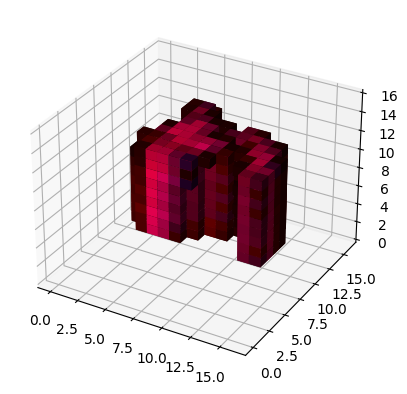

 84%|████████▍ | 4200/5001 [49:14<09:22,  1.42it/s]

T_loss: -1.1653462168439737e+26;  f_loss: 5.538302866737966e+24


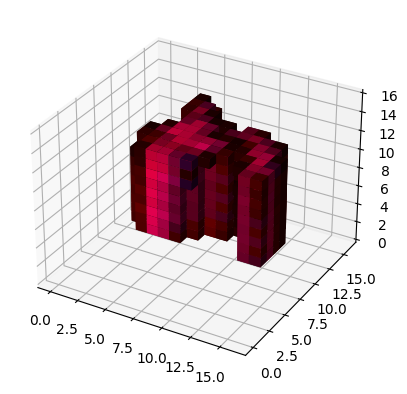

 86%|████████▌ | 4300/5001 [50:24<08:09,  1.43it/s]

T_loss: -1.1654911160186727e+26;  f_loss: 8.856992029434794e+24


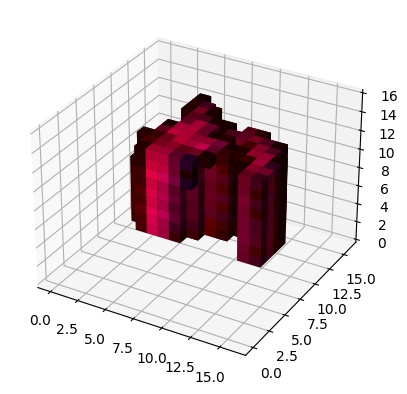

 88%|████████▊ | 4400/5001 [51:34<06:57,  1.44it/s]

T_loss: -1.1980780272946435e+26;  f_loss: 1.2120977372581035e+25


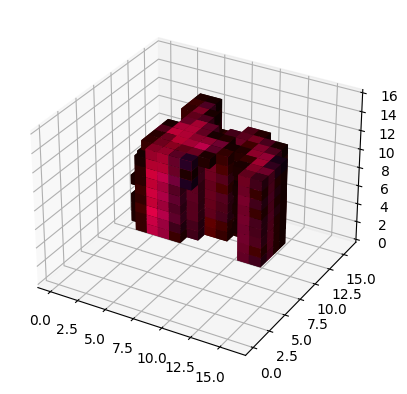

 90%|████████▉ | 4500/5001 [52:45<05:50,  1.43it/s]

T_loss: -1.2756297995874851e+26;  f_loss: -1.1389148918316793e+25


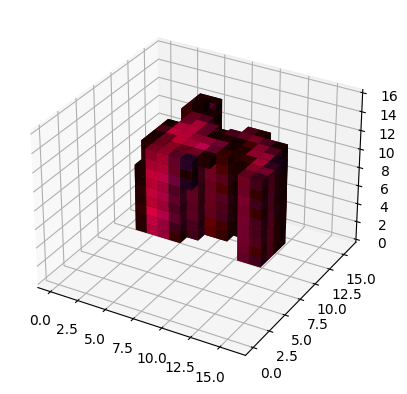

 92%|█████████▏| 4600/5001 [53:55<04:40,  1.43it/s]

T_loss: -1.319906228115525e+26;  f_loss: -9.538331745169293e+24


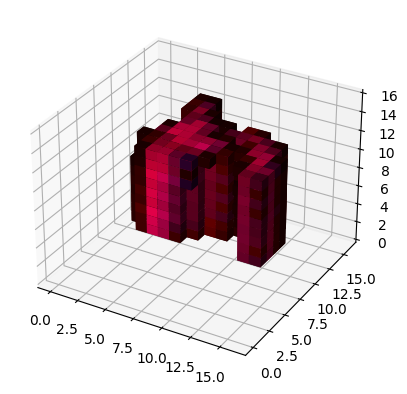

 94%|█████████▍| 4700/5001 [55:05<03:30,  1.43it/s]

T_loss: -1.2900044249069233e+26;  f_loss: 1.894222361952939e+24


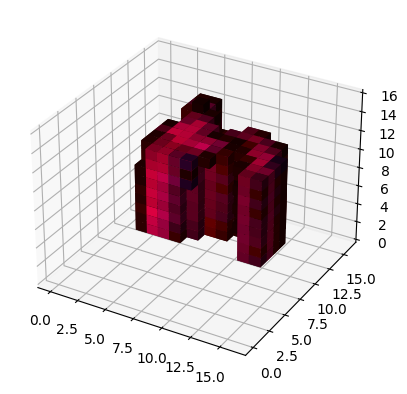

 96%|█████████▌| 4800/5001 [56:15<02:20,  1.43it/s]

T_loss: -1.3317357561551135e+26;  f_loss: 1.267235977631625e+25


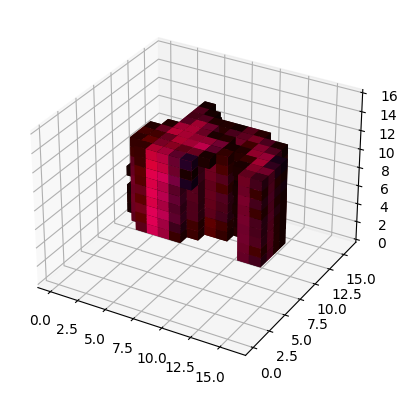

 98%|█████████▊| 4900/5001 [57:26<01:10,  1.43it/s]

T_loss: -1.2641597985898933e+26;  f_loss: -9.437262034389438e+24


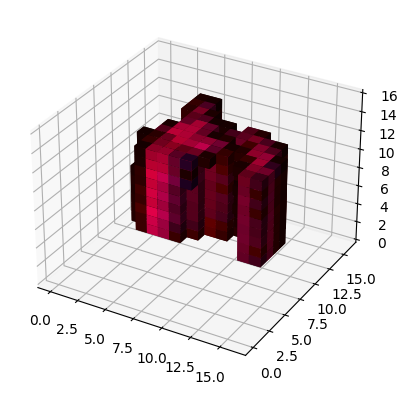

100%|█████████▉| 5000/5001 [58:36<00:00,  1.43it/s]

T_loss: -1.3578309814903848e+26;  f_loss: -1.1092414593147101e+25


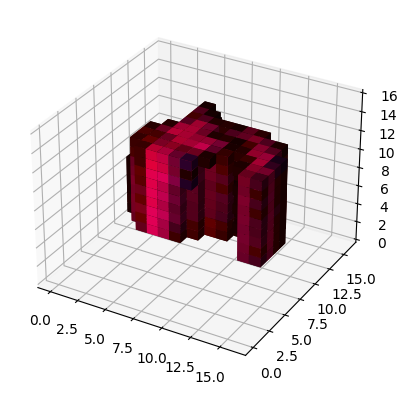

100%|██████████| 5001/5001 [58:37<00:00,  1.42it/s]


In [13]:
test_batch = sample_test().to(device=device, dtype=torch.float)
plot_img(test_batch[0])
f_losses = []
T_losses = []

imgs = []

for step in tqdm(range(5001)):
    # clear_output(wait=True)

    # Training T, freezing f
    T.train(True)
    f.eval()
    
    for i in range(10):
        X = sample_train_a().to(device=device, dtype=torch.float)

        T_X = T(X)
        T_loss = sq_cost(X, T_X).mean() - f(T_X).mean()
        T_opt.zero_grad()
        T_loss.backward()
        T_opt.step()
    

    # Training f, freezing T
    f.train(True)
    T.eval()

    X = sample_train_a().to(device=device, dtype=torch.float)
    Y = sample_train_b().to(device=device, dtype=torch.float)

    with torch.no_grad():
        T_x = T(X)
    
    f_loss = f(T_x).mean() - f(Y).mean()
    f_opt.zero_grad()
    f_loss.backward()
    f_opt.step()

    if not step % 100:
        print(f"T_loss: {T_loss}; ", end="")
        print(f" f_loss: {f_loss}")
        T_X = torch.clip(T(test_batch.to(device=device, dtype=torch.float))[0].cpu().detach(), min=0, max=1)
        T_X[T_X < np.quantile(T_X, 0.92)] = 0
        plot_img(T_X)

    # Save OT map every 1000 steps
    if not step % 1000:
        save_model(step, T, f, T_opt, f_opt, T_loss, f_loss, f"weights/OT_transfer_30000_{step}.pt")

    gc.collect()
    torch.cuda.empty_cache()

In [53]:
test_batch = sample_test().to(device=device, dtype=torch.float)

0


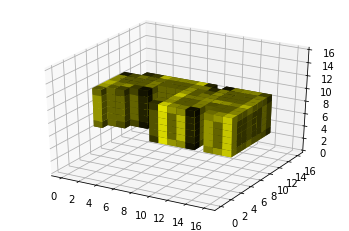

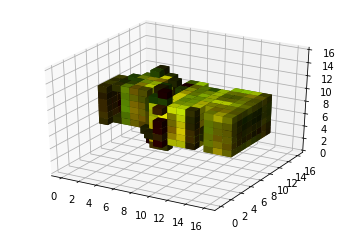

1


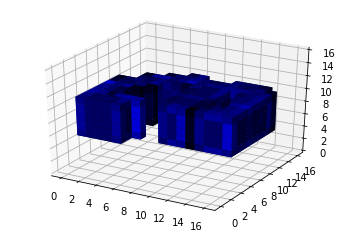

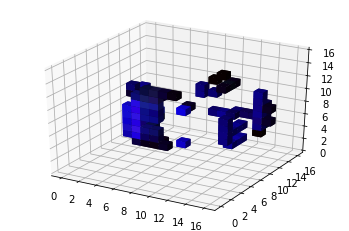

2


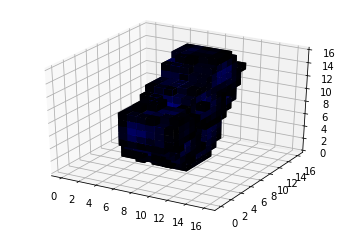

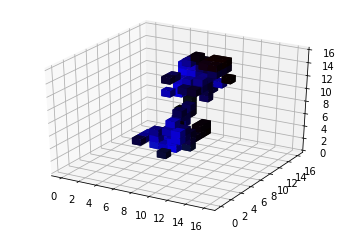

3


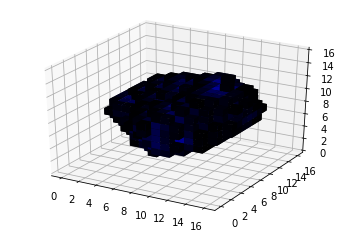

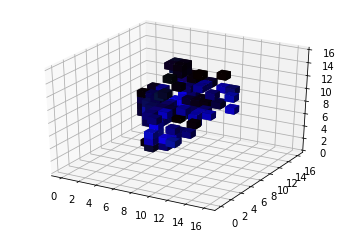

4


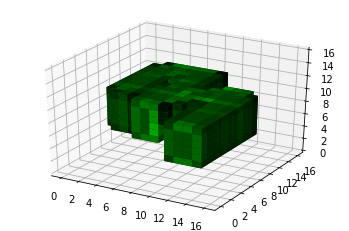

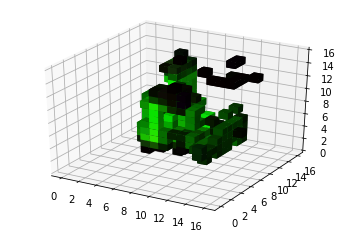

In [54]:
for i in range(5):
    print(i)
    plot_img(test_batch[i].cpu())

    T_X = torch.clip(T(test_batch)[i].cpu().detach(), min=0, max=1)
    T_X[T_X < np.quantile(T_X, 0.92)] = 0
    plot_img(T_X)